# Movie Recommender

In this notebook, I have attempted to create a Movie Recommender System, using a **10M version of the MovieLens dataset** . Following files comprised the dataset:

1. movies.dat : a table file having information for 10,000 movies
2. ratings.dat : a table file containing 10,000,000 user-ratings
3. tags.dat : a table file consisting of various tags associated with a movie 

You can download the data here: http://grouplens.org/datasets/movielens/10m/

The recommendations are divided into four parts:
1. Rating based : A simple recommender combining movie's popularity and average rating
2. Genre based : Calculating genre based ratings for top recommendations
3. Movie based : A content - based recommender, recommending similar movies
4. User based : Based on *Collaborative Filtering* , this recommender gives out top movies a user is more likely to watch

I have tried to proceed in a step by step manner, let's begin.


## Step 1:

Import the required libraries: 
  - Pandas and Numpy for data processing
  - Matplotlib for visualisation
  - Nltk for text processing of tags
  - Sklearn for accessing cosine similarity metric
  - Surprise library for singular value decomposition for collaborative filtering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF,NormalPredictor,KNNBaseline,KNNBasic,KNNWithMeans, KNNWithZScore,BaselineOnly, CoClustering
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')

## Step 2:

Load the data into dataframes and explore the various data heads
  - Check for null values in the datasets
  - Handle the missing values (fillna or dropna)
  - Check for unnecessary feature values and remove the anomalies
  

In [2]:
movies=pd.read_csv('movies.dat', sep = '::',names = ['MovieID','Title','Genre'])
ratings=pd.read_csv('ratings.dat', sep = '::',names = ['UserID','MovieID','Rating','Timestamp'])
tags=pd.read_csv('tags.dat', sep = '::',names = ['UserID','MovieID','Tag','Timestamp'])

In [3]:
movies.head()

,MovieID,Title,Genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [5]:
tags.head()

,UserID,MovieID,Tag,Timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


In [6]:
movies.isnull().any()

MovieID    False
Title      False
Genre      False
dtype: bool

In [7]:
ratings.isnull().any()

UserID       False
MovieID      False
Rating       False
Timestamp    False
dtype: bool

In [8]:
tags.isnull().any()

UserID       False
MovieID      False
Tag           True
Timestamp    False
dtype: bool

In [9]:
tags = tags.fillna('')

In [10]:
tags.isnull().any()

UserID       False
MovieID      False
Tag          False
Timestamp    False
dtype: bool

In [11]:
movies['Genre'].value_counts()[-10:]

Adventure|Fantasy|Mystery                   1
Adventure|IMAX|Romance                      1
Animation|Comedy|Drama|Fantasy|Sci-Fi       1
Animation|Drama|Mystery|Sci-Fi|Thriller     1
Action|Drama|Musical|Romance                1
Animation|Comedy|Fantasy|Musical|Romance    1
Animation|Fantasy|Thriller                  1
Animation|Crime|Mystery                     1
Adventure|Horror|Thriller                   1
Animation|Children|Comedy|Crime             1
Name: Genre, dtype: int64

In [12]:
movies = movies.drop(movies[movies['Genre']=='(no genres listed)'].index)

## Step 3

Visualising the data:
 - Combine the datasets and explore the relation between different features
 - Note the imbalance and trends (if any) in the dataset for feature engineering

In [13]:
# separating genres for each movie
genre_list = movies.apply(lambda x: pd.Series(x['Genre'].split('|')),axis=1).stack().reset_index(level=1, drop=True)
genre_list.name = 'Genre'
movies_new = movies.drop('Genre', axis=1).join(genre_list)

In [14]:
movies_new.head(10)

,MovieID,Title,Genre
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy
1,2,Jumanji (1995),Adventure
1,2,Jumanji (1995),Children
1,2,Jumanji (1995),Fantasy
2,3,Grumpier Old Men (1995),Comedy
2,3,Grumpier Old Men (1995),Romance


In [15]:
# merging dataframe movies with ratings i.e mapping each movie to different user ratings given
movie_rating = movies_new.join(ratings.set_index('MovieID'), on='MovieID')

In [16]:
movie_rating[movie_rating['UserID']==5]

,MovieID,Title,Genre,UserID,Rating,Timestamp
0,1,Toy Story (1995),Adventure,5.0,1.0,857911264.0
0,1,Toy Story (1995),Animation,5.0,1.0,857911264.0
0,1,Toy Story (1995),Children,5.0,1.0,857911264.0
0,1,Toy Story (1995),Comedy,5.0,1.0,857911264.0
0,1,Toy Story (1995),Fantasy,5.0,1.0,857911264.0
...,...,...,...,...,...,...
1271,1300,My Life as a Dog (Mitt liv som hund) (1985),Comedy,5.0,4.0,857913553.0
1271,1300,My Life as a Dog (Mitt liv som hund) (1985),Drama,5.0,4.0,857913553.0
1360,1391,Mars Attacks! (1996),Action,5.0,1.0,857911690.0
1360,1391,Mars Attacks! (1996),Comedy,5.0,1.0,857911690.0


In [17]:
movie_rating=movie_rating.drop('Timestamp',axis=1)

In [18]:
ratings['Rating'].describe()

count    1.000005e+07
mean     3.512422e+00
std      1.060418e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

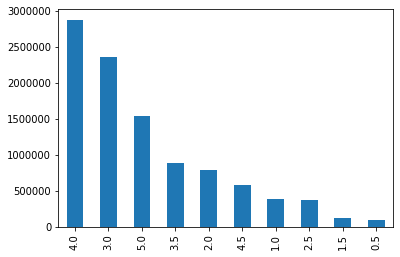

In [19]:
#Distribution of ratings accross dataset
ratings['Rating'].value_counts().plot(kind='bar')
plt.show()

From the graph and the stats above we can see that people have been generous in their ratings as it averages out around 3.5, implying more than 50% of movies have been rated between 3 to 4.

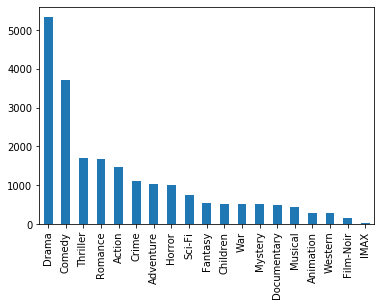

In [20]:
#distribution of genres across movies listed
movies_new['Genre'].value_counts().plot(kind='bar')
plt.show()

More than 50% of the movies in the dataset belong to 'Drama' category, seconded by 'Comedy'. 

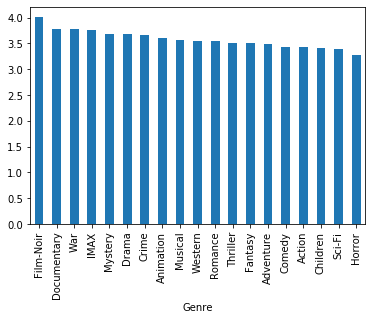

In [21]:
#disribution of genre with average rating over dataset
movie_rating.groupby('Genre').mean()['Rating'].sort_values(ascending = False).plot(kind='bar')

And 'the most loved genre' goes to... No peculiar trend here, just evenly distributed ratings! The ratings have been averaged out. Note it shows that 'Film Noir' rates better on average than other genres, however the population distribution of the genre is very low and thus nothing could be concluded about the actual popularity and rating of the genre.

In [22]:
movie_rating2 = movies.join(ratings.set_index('MovieID'), on='MovieID')

In [23]:
movie_rating2 = movie_rating2.dropna()

In [24]:
tot_users = len(movie_rating['UserID'].unique())

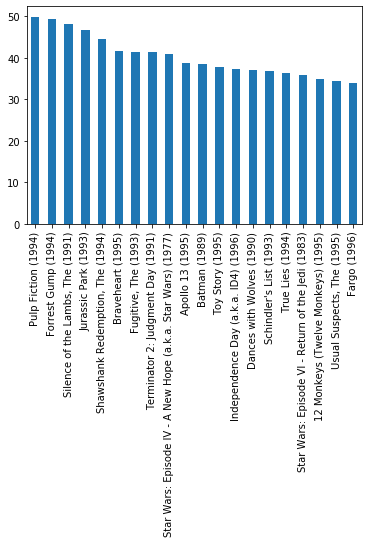

In [25]:
#populatrity (% users rated) distribution of movies in the dataset; top-20 popular
(movie_rating2['Title'].value_counts()[:20]*100/tot_users).plot(kind='bar')

Let's see the top-20 popular movies in the dataset. We see some interesting movies here,even favourites like - *Shawshank Redemption* , *Jurassic Park* ,*Star Wars* and ever so popular *Pulp fiction*

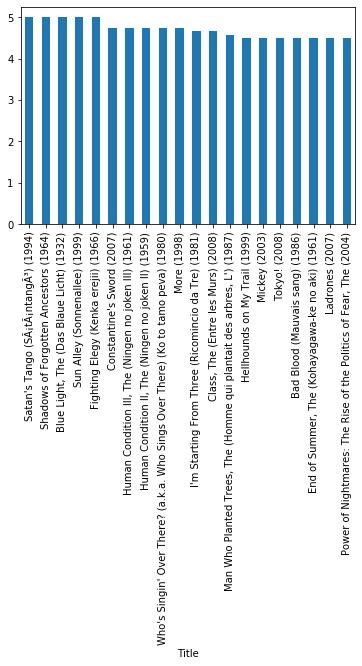

In [26]:
# avg-rating of movies over the datset ;  top-20 rated movies
movie_rating2.groupby('Title').mean()['Rating'].sort_values(ascending = False)[:20].plot(kind='bar')

However, the top-20 rated movies don't ring any bells. So either I missed really good cinema or these movies are really unpopular.

Now, for recommendations we assume the rule of majority. One is more likely to watch a popular movie with decent rating than a movie rated 5 which no-one has heard of. 

So to level the playing field we will factor in the number of votes into our rating.


## Step 4: Processing data for Recommendations 



## Rating Based Recommender 

For our first recommender we will use the IMDB's weighted rating formula. We will be using this rating metric for other recommenders as well.


$ Weighted Rating = (\frac{v}{v+m}.R) + (\frac{m}{v+m}.C) $

where,
   -  v is the number of vote counts for a movie
   -  m is the minimum number of votes required for featuring in recommendation
   -  R is the average rating of the movie
   -  C is the mean vote across the ratings chart
       

In [27]:
r=movie_rating2.groupby('MovieID').mean()['Rating']
p=movie_rating2['MovieID'].value_counts()

In [28]:
p.name = 'Rating Count'
r.name = 'Mean Rating'

In [29]:
movies = movies.join(r,on='MovieID')
movies = movies.join(p,on='MovieID')

In [30]:
movies_new = movies_new.join(r,on='MovieID')
movies_new = movies_new.join(p,on='MovieID')

In [31]:
# calculating average reating (C) and minimum votes required (m)
# for m, capping the number of votes at 80 percentile
r_avg = movies['Mean Rating'].mean()
p_min = movies['Rating Count'].quantile(.80)

In [32]:
movies_filtered = movies[movies['Rating Count']>p_min]

In [33]:
def weighted_rating(x,r_avg,p_min):
    p = x['Rating Count']
    r = x['Mean Rating']
    return (p*r)/(p+p_min) + (p_min*r_avg)/(p+p_min)

In [34]:
movies_filtered['wt_rating'] = movies_filtered.apply(weighted_rating,axis=1,args=[r_avg,p_min])

In [35]:
movies_filtered = movies_filtered.sort_values(by = 'wt_rating',ascending = False)

In [36]:
movies_filtered.head(10)

,MovieID,Title,Genre,Mean Rating,Rating Count,wt_rating
315,318,"Shawshank Redemption, The (1994)",Drama,4.457238,31126.0,4.420682
843,858,"Godfather, The (1972)",Crime|Drama,4.415085,19814.0,4.360473
49,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.367142,24037.0,4.323547
523,527,Schindler's List (1993),Drama|War,4.363483,25777.0,4.322856
895,912,Casablanca (1942),Drama|Romance,4.319741,12507.0,4.241994
1195,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.303215,13281.0,4.230781
1169,1193,One Flew Over the Cuckoo's Nest (1975),Comedy|Drama,4.292380,14435.0,4.226041
1173,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.261317,21803.0,4.217749
737,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.298072,11774.0,4.217418
887,904,Rear Window (1954),Mystery|Thriller,4.316544,8825.0,4.209744


Now, we are talking . These are truly the must-watch movies , rightly popular and now appropriately rated.


Let's look at our old movie set and the number of ratings for each movie. 

We see all the 'top-20 rated' movies have ratings close or equal to 5, while the number of ratings barely cross 10. ( no wonder I hadn't heard of them )

In [37]:
movies.sort_values(by = 'Mean Rating',ascending = False).head(10)

,MovieID,Title,Genre,Mean Rating,Rating Count
9408,42783,Shadows of Forgotten Ancestors (1964),Drama|Romance,5.00,1.0
10614,64275,"Blue Light, The (Das Blaue Licht) (1932)",Drama|Fantasy|Mystery,5.00,1.0
9083,33264,Satan's Tango (SÃ¡tÃ¡ntangÃ³) (1994),Drama,5.00,2.0
9805,51209,Fighting Elegy (Kenka erejii) (1966),Action|Comedy,5.00,1.0
9911,53355,Sun Alley (Sonnenallee) (1999),Comedy|Romance,5.00,1.0
8416,26048,"Human Condition II, The (Ningen no joken II) (...",Drama|War,4.75,4.0
5098,5194,Who's Singin' Over There? (a.k.a. Who Sings Ov...,Comedy,4.75,4.0
10670,65001,Constantine's Sword (2007),Documentary,4.75,2.0
4361,4454,More (1998),Animation|IMAX|Sci-Fi,4.75,8.0
8423,26073,"Human Condition III, The (Ningen no joken III)...",Drama|War,4.75,4.0


In [38]:
#just created a function out of it
def RecommendByTopRated():
    return movies_filtered[['MovieID','Title','Genre','wt_rating']][:20]

In [39]:
RecommendByTopRated()

,MovieID,Title,Genre,wt_rating
315,318,"Shawshank Redemption, The (1994)",Drama,4.420682
843,858,"Godfather, The (1972)",Crime|Drama,4.360473
49,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.323547
523,527,Schindler's List (1993),Drama|War,4.322856
895,912,Casablanca (1942),Drama|Romance,4.241994
1195,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.230781
1169,1193,One Flew Over the Cuckoo's Nest (1975),Comedy|Drama,4.226041
1173,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.217749
737,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.217418
887,904,Rear Window (1954),Mystery|Thriller,4.209744


So now we have our top-20 rated movies, but they are still not the movies you might want to watch.

Since most popular genre of our dataset was 'Drama' , most of the movies listed here are 'Drama'. Also mysteries, crime are some highly rated genres and thus feature often in recommendations . 

What if you wanted a different genre, probably animation, or Horror?

## Genre Based Recommender

To avoid the genre based bias, we create separate recommendations for each genre. We calculate the weighted ratings for movies only belonging to the desired genre, thus keeping the ratings relative.

In [40]:
#recommender for genre wise recommendations

def RecommendByGenre(genre):
    sample_space = movies_new[movies_new['Genre']==genre]
    p_min = sample_space['Rating Count'].quantile(.80)
    r_avg = sample_space['Mean Rating'].mean()
    sample_space['wt_rating'] = sample_space.apply(weighted_rating,axis=1,args=[r_avg,p_min])
    sample_space = sample_space.sort_values(by='wt_rating',ascending = False)
    return sample_space[['MovieID','Title','wt_rating']][:20]
    

In [44]:
'''Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Film-Noir', 'Western', '(no genres listed)'''

RecommendByGenre('Horror')

,MovieID,Title,wt_rating
587,593,"Silence of the Lambs, The (1991)",4.171288
1193,1219,Psycho (1960),4.000530
46,47,Seven (a.k.a. Se7en) (1995),3.988572
1188,1214,Alien (1979),3.977802
1175,1200,Aliens (1986),3.939718
1230,1258,"Shining, The (1980)",3.924311
1250,1278,Young Frankenstein (1974),3.911940
1356,1387,Jaws (1975),3.771455
8170,8874,Shaun of the Dead (2004),3.707298
1913,1997,"Exorcist, The (1973)",3.662361


Great! Now, we have movie recommendations for each genre, however they are still redundant and ignorant of a user's personal preferances. 

## Content Based Recommender

In this section, we will give recommendations of movies similar to an input movie. To capture these similarities , we will explore the tags dataset. Let's look at some of most popular tags

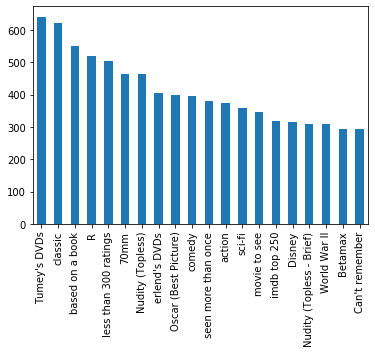

In [43]:
tags['Tag'].value_counts()[:20].plot(kind='bar')

Seems like there are many movies 'based on a book' , 'classic' or available on 'tumey's DVDs'. Combining movies having similar tags can result in movies having somewhat similar content.

P.S : To be able to have a robust segregation, we needed more data like, movie summary or cast and crew information, but since the data available here is just tags, we will make do with it

### Cleaning the tags data

Before using tags in our recommenation system , we must preprocess them :

- Convert to lowercase and remove punctuation
- Apply stemming to tags and convert them into only root words
- Remove the tags having rare occurences

In [45]:
import string
punct = string.punctuation
def full_remove(x, removal_list):
    
    for w in removal_list:
        x = x.replace(w,'')
    return x

In [46]:
tags['clean_tag'] = tags['Tag'].apply(lambda x: x.lower())
tags['clean_tag'] = tags['clean_tag'].apply(full_remove,args=[punct])

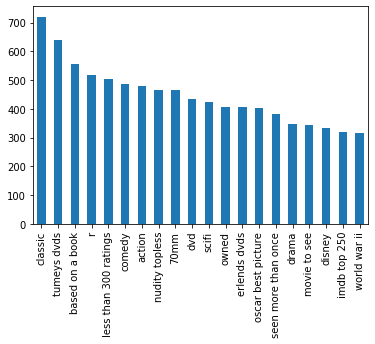

In [47]:
tags['clean_tag'].value_counts()[:20].plot(kind = 'bar')

In [48]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [49]:
data = ' '.join(tags['clean_tag'].values)

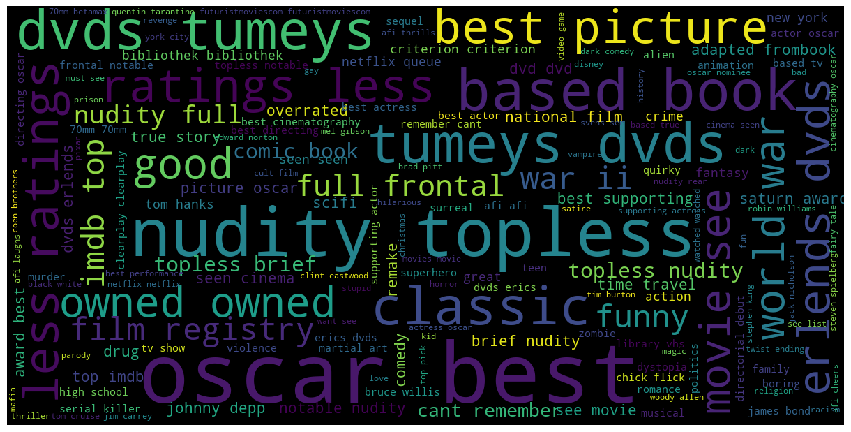

In [50]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data)

In [51]:
stemmer = SnowballStemmer('english')
def stem(x):
    words = x.split()
    w = []
    for i in words:
        if i.isalnum():
            w.append((stemmer.stem(i)))
    return ' '.join(w)

In [52]:
tags['clean_tag'] = tags['clean_tag'].apply(stem)
tags['clean_tags2'] = tags['clean_tag'].apply(lambda x:x.replace(' ',''))

In [53]:
ct = tags.groupby(['MovieID'])

tgs = ct['clean_tag'].apply(lambda x: list(x.values))
tgs = tgs.apply(lambda x: list(set(x)))
tgs.name = 'tag_unique'

tgs2 = ct['clean_tags2'].apply(lambda x: list(x.values))
tgs2 = tgs2.apply(lambda x: list(set(x)))
tgs2.name = 'tag_unique2'

In [54]:
df = pd.DataFrame(tgs)
df = df.join(tgs2)

In [55]:
df.head()

,tag_unique,tag_unique2
MovieID,,
1,"[humor, , clever, want, toy come to life, rous...","[humor, , clever, erlenddvds, want, rous, tima..."
2,"[monkey, for children, see alsozathura, time, ...","[monkey, childhoodrecaptur, time, saturnawardb..."
3,"[grun run, moldi, sequel fever, comedinha de v...","[jacklemmon, moldi, comedinhadevelhinho, funni..."
4,[girl movi],[girlmovi]
5,"[fantasi, remak, sequel fever, sequel, childho...","[fantasi, remak, sequel, worstmoviever, childh..."


In [56]:
tags_set = df.apply(lambda x: pd.Series(x['tag_unique']),axis=1).stack().reset_index(level=1, drop=True)

In [57]:
tags_set = tags_set.value_counts()
min_v = tags_set.quantile(.80)
print('Capping at:',min_v)
tags_set = tags_set[tags_set>min_v]

Capping at: 3.0


In [58]:
tags_set2 = df.apply(lambda x: pd.Series(x['tag_unique2']),axis=1).stack().reset_index(level=1, drop=True)

In [59]:
tags_set2 = tags_set2.value_counts()
min_v2 = tags_set2.quantile(.80)
print('Capping at:',min_v2)
tags_set2= tags_set2[tags_set2>min_v2]

Capping at: 3.0


In [60]:
def filter(x,tags_set):
    lis = []
    for i in x:
        if i in tags_set:
            lis.append(i)
    return lis

In [61]:
df['tag_unique'] = df['tag_unique'].apply(filter,args=[tags_set])
df['tag_unique2'] = df['tag_unique2'].apply(filter,args=[tags_set2])

As we have our list of filtered tags mapped to Movie-Ids , let's join it with movies dataset.

In [81]:
filtered_movies_tag = movies.join(df,on='MovieID')

In [82]:
filtered_movies_tag['tag_unique'] = filtered_movies_tag['tag_unique'].fillna('')
filtered_movies_tag['tag_unique2'] = filtered_movies_tag['tag_unique2'].fillna('')

In [83]:
filtered_movies_tag['tag_unique'] = [i if isinstance(i, list) else [] for i in filtered_movies_tag['tag_unique']]
filtered_movies_tag['tag_unique2'] = [i if isinstance(i, list) else [] for i in filtered_movies_tag['tag_unique2']]

In [84]:
filtered_movies_tag['Genre'] = filtered_movies_tag['Genre'].apply(lambda x:x.split('|'))

To compute the similarity, we will also include genres to our list of features.

### Computing Similarity

- Use a count vectorizer to create a count matrix for words in features_mix, and each row representing each movie
- Using cosine similarity function (dot product) , compute the similarities between each pair of movies, making a similarity matrix
- Similarity score at i, j in similarity matrix represents how close movies at index i and j are to each other 

In [85]:
filtered_movies_tag['features_mix'] = filtered_movies_tag['tag_unique']+filtered_movies_tag['Genre']
filtered_movies_tag['features_mix'] = filtered_movies_tag['features_mix'].apply(lambda x: ' '.join(x))

In [86]:
filtered_movies_tag.head()

,MovieID,Title,Genre,Mean Rating,Rating Count,tag_unique,tag_unique2,features_mix
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.928769,26449.0,"[humor, , clever, want, rous, disney anim feat...","[humor, , clever, erlenddvds, want, rous, tima...",humor clever want rous disney anim featur tom...
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.208070,12032.0,"[monkey, time, robin william, anim, scari, fan...","[monkey, time, saturnawardbestspecialeffect, a...",monkey time robin william anim scari fantasi s...
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.150385,7790.0,"[sequel fever, jack lemmon, funniest movi, wal...","[jacklemmon, funniestmovi, sequelfever, old, w...",sequel fever jack lemmon funniest movi walter ...
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.860544,1764.0,[],[],Comedy Drama Romance
4,5,Father of the Bride Part II (1995),[Comedy],3.077435,7135.0,"[fantasi, remak, sequel fever, sequel, childho...","[fantasi, remak, sequel, worstmoviever, childh...",fantasi remak sequel fever sequel childhood cl...


In [87]:
counter = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = counter.fit_transform(filtered_movies_tag['features_mix'])

In [88]:
len(filtered_movies_tag) , count_matrix.shape

(10680, (10680, 40868))

In [89]:
sim_matrix = cosine_similarity(count_matrix, count_matrix)

In [90]:
sim_matrix.shape

(10680, 10680)

In [91]:
filtered_movies_tag = filtered_movies_tag.reset_index()
titles = filtered_movies_tag['Title']
indices = pd.Series(filtered_movies_tag.index, index=filtered_movies_tag['Title'])

Our recommender takes a movie as an input and reports its top-50 similar movies. To ensure qualtiy recommendations , we again calculate the weighted ratings in these 50 movies and report the top-20 rated movies, ensuring both quality and similarity.

Let's see it at work.

In [94]:
def RecommendByMovie(title):
    idx = indices[title]
    sim_score = list(enumerate(sim_matrix[idx]))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
    sim_score = sim_score[1:50]
    movie_indices = [i[0] for i in sim_score]
    
    sample_space = filtered_movies_tag[['Title','MovieID','Rating Count','Mean Rating']].iloc[movie_indices]
    p_min = sample_space['Rating Count'].quantile(.50)
    r_avg = sample_space['Mean Rating'].mean()
    sample_space['wt_rating'] = sample_space.apply(weighted_rating,axis=1,args=[r_avg,p_min])
    sample_space = sample_space.sort_values(by='wt_rating',ascending = False)
    return sample_space[['MovieID','Title','wt_rating']][:20]
    
    #return movies_filtered[['Title','wt_rating']].iloc[movie_indices]

In [95]:
RecommendByMovie('Batman Returns (1992)')

,MovieID,Title,wt_rating
9126,33794,Batman Begins (2005),3.876729
5253,5349,Spider-Man (2002),3.583309
9246,37733,"History of Violence, A (2005)",3.435564
586,592,Batman (1989),3.376878
2556,2640,Superman (1978),3.359335
3128,3213,Batman: Mask of the Phantasm (1993),3.260346
8899,31696,Constantine (2005),3.202085
10311,60040,"Incredible Hulk, The (2008)",3.162662
9552,46530,Superman Returns (2006),3.123738
2557,2641,Superman II (1980),3.093244


## Step 5 : Collaborative Filtering

Collaborative filtering explores relationship between users and their product choices. Remember those 'other users have also bought' recommendations on e-commerce sites, it's one of its examples. 

It fills a sparse user-product matrix (mostly using singular value decomposition (SVD) ) allowing us to factor in the similarities between the users in our predictions. 

- In our problem, it will be predicting ratings for an un-rated movie for user A, based on the ratings of that movie given by other users who resemble A's behaviour. 

- We will be using Surprise Library , which is primarily dedicated to building and analyzing recommender systems.

- To choose a prediction algorithm, we will perform a cross validation on a sampled User-Ratings data, and will select the algorithm with least RMSE (root mean squared error) on test set 

In [97]:
#Collaborative Filtering

In [98]:
#to convert the dataframe into dataset
reader = Reader()

In [99]:
#sampling data for cross validation
sample = ratings.sample(n=20000)

In [100]:
data = Dataset.load_from_df(sample[['UserID','MovieID','Rating']],reader)

In [101]:
#Choose from the similarity algorithms present using cross validation and then comparing the accuracy
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3,verbose=False)
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.007867,1.477013,0.104743
SVD,1.009243,0.867066,0.057841
BaselineOnly,1.009851,0.087856,0.030567
KNNBaseline,1.010730,2.520991,0.085576
KNNBasic,1.058859,2.653482,0.227369
KNNWithZScore,1.139002,2.860078,0.132398
NMF,1.139308,1.763945,0.034484
SlopeOne,1.140570,0.286007,0.056594
KNNWithMeans,1.140787,2.875875,0.112560


SVDpp gives us the best accuracy and thus we will model the rest of our data over it

### Running SVDpp

- Convert the **ratings dataframe** to dataset object
- Split the dataset into train and test datasets
- Fit the model over train-set and get predictions and accuracy for test-set

In [106]:
# SVDpp gives us the best test acccuracy and thus we will model rest of the data over it
ratings_data = Dataset.load_from_df(ratings[['UserID','MovieID','Rating']],reader)

In [108]:
#split the data into test and train set to check model accuracy
train, test = train_test_split(ratings_data, test_size=.3)

In [ ]:
model = SVDpp()
model.fit(train)

In [ ]:
predictions = model.test(test)
print(accuracy.rmse(predictions))   #rmse accuracy for the model

In [ ]:
predicted_rating = [i.est for i in predictions]

In [ ]:
test_set = pd.DataFrame(test,columns=['UserID','MovieID',"Rating"])
test_set['Predicted Rating'] = predicted_rating

In [ ]:
#Comparison of actual and predicted ratings for test set
test_set.head(10)

## User Based Recommender

We will make two kinds of recommenders:

1. Top-User Rated :
    - Take in the UserID as Input.
    - Fetch the user's ratings (predicted/given) of all the movies
    - Report top-20 rated movies

2. Top-User Rated plus similar movies:
    - Take in the UserID as Input
    - Fetch top-10 rated movies by that user
    - Get top 20 similar movies for each of these 10 movies
    - Filter the unique movies and sort them according to User Rating
    - R

In [85]:
def RecommendByUser_TopPicks(UID):
    mvs = pd.DataFrame(movies_filtered)
    mvs['Predicted User Rating'] = mvs['MovieID'].apply(lambda x: model.predict(UID,x).est)
    mvs = mvs.sort_values(by = 'Predicted User Rating',ascending = False)
    result = mvs[:20]
    mid = result['MovieID']
    #result['Actual User Rating'] = ratings[ratings['UserID']==UID][ratings.MovieID.isin(mid)]['Rating']
    return result[['MovieID','Title','wt_rating','Predicted User Rating']]#,'Actual User Rating']]

In [86]:
RecommendByUser_TopPicks(111)

,MovieID,Title,wt_rating,Predicted User Rating
2874,2959,Fight Club (1999),4.136484,4.619039
10216,58559,"Dark Knight, The (2008)",4.005026,4.473441
2418,2502,Office Space (1999),3.899014,4.442909
3348,3435,Double Indemnity (1944),4.002917,4.424520
9179,34405,Serenity (2005),3.745126,4.420964
5916,6016,City of God (Cidade de Deus) (2002),4.074813,4.412717
4784,4878,Donnie Darko (2001),3.948683,4.399662
1169,1193,One Flew Over the Cuckoo's Nest (1975),4.226041,4.399631
49,50,"Usual Suspects, The (1995)",4.323547,4.386708
843,858,"Godfather, The (1972)",4.360473,4.377502


In [87]:
def RecommendByUser2_TopPicks(UID):
    mr = movie_rating[movie_rating['UserID'] == UID].sort_values(by='Rating',ascending=False)
    mr = mr.drop_duplicates(subset=['Title'], keep='first', inplace=False)[:10]
    mvs = mr['Title'].unique()
    df = pd.DataFrame()
    for mv in mr['Title']:
        mv_lis = RecommendByMovie(mv)[:5]
        mv_lis['Predicted User Rating'] = mv_lis['MovieID'].apply(lambda x: model.predict(UID,x).est)
        df=df.append(mv_lis[['MovieID','Title','wt_rating','Predicted User Rating']]) 
    
    df = df.drop_duplicates(subset=['Title'], keep='first', inplace=False)
    return df.sort_values(by='Predicted User Rating',ascending = False)
    

In [88]:
RecommendByUser2_TopPicks(111)[:20]

,MovieID,Title,wt_rating,Predicted User Rating
6,1193,One Flew Over the Cuckoo's Nest (1975),4.208731,4.399631
2,50,"Usual Suspects, The (1995)",4.285997,4.386708
1,858,"Godfather, The (1972)",4.307526,4.377502
0,318,"Shawshank Redemption, The (1994)",4.371515,4.351780
5,1221,"Godfather: Part II, The (1974)",4.211303,4.332635
20,4226,Memento (2000),4.119197,4.289480
4,912,Casablanca (1942),4.218984,4.251738
11,593,"Silence of the Lambs, The (1991)",4.173686,4.181173
25,296,Pulp Fiction (1994),4.123394,4.173125
3,527,Schindler's List (1993),4.298700,4.169063
